#  🚀 Lunar Lander 🛸 with Least Squares Policy Iteration (LSPI) :

This notebook implements [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) as available through [Farama Foundation Gymnasium](https://gymnasium.farama.org/).  The algorithm utilized is [LSPI](https://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf) with a some differences as noted (e.g. weight updates). All figures provided are from the [LSPI](https://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf) paper by [Lagoudakis](https://scholar.google.com/citations?user=VqHiIg8AAAAJ) and [Parr](https://scholar.google.com/citations?user=b-GJ3QIAAAAJ).

## Install Required Packages

In [1]:
'''
Lunar Lander with LSPI
Author: Nirav Lad
'''

from IPython.display import Video, clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install swig
    !pip install gymnasium[box2d]
    !pip install moviepy

    clear_output(wait=True)
    print("Package installs complete.")

## Import Libraries

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import gymnasium as gym

import random
import scipy.stats as stats

import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip, concatenate_videoclips

import os
import time

## Define Parameters

In [3]:
# Environment name
ENV = 'LunarLander-v2'

# Significance for 95CI
CI = 0.95

# Number of best candidate scores to record
NUM_BEST_SCORES = 10

# Enable wind for environment
ENABLE_WIND = False

# Strings for folders
VIDEO_FOLDER = "videos/"
WEIGHTS_FOLDER = "weights/"
PLOTS_FOLDER = "plots/"

In [4]:
# Create an environment
env = gym.make(ENV)

# Length of state/observation tuple
S_SIZE = len( env.observation_space.low )

# Number of actions in action space
ACTIONS = np.arange( env.action_space.n )

# Close environment
env.close()

## Define Hyperparameters

These require tuning.

In [5]:
# DELTA to avoid matrix signularities
DELTA = 1e-3

# GAMMA for discount factor
GAMMA = 0.9

# ALPHA for learning rate / smoothing
ALPHA = 0.99

## Mean and halfwidth calculation function

In [6]:
def mean_hw(data):
    n = np.size(data)
    stdError = np.std(data) / np.sqrt(n)
    t_crit = stats.t.ppf( 1 - (1 -CI) / 2, n - 1 )
    mean = np.mean(data)
    halfWidth = t_crit * stdError
    return( mean, halfWidth )

## Basis functions

$\phi(s,a) = \begin{pmatrix} \phi_1(s,a)\times I(a=1) \\ \phi_2(s,a)\times I(a=2) \\ \vdots \\ \phi_k(s,a)\times I(a=k)\end{pmatrix}$ where $\phi_i(s,a) = state$.

In [7]:
# Basis function
def phi(state, action):
    return( np.hstack( [ state * ( action == a ) for a in ACTIONS ] ) )

## Poilicy function ($\pi$)

$\pi(s) =\arg \max_{a \in \mathcal{A}} \phi(s,a)^{\intercal} w$

In [8]:
# Policy function
def policy( state, w ):
    return( np.argmax( [ np.dot( phi(state, action ), w ) for action in ACTIONS ] ) )

## Policy observation / sample / evaluation function


In [9]:
def observe_env( w,
                 num_episodes = 30,
                 seed = 42,
                 render_mode = None,
                 enable_wind = ENABLE_WIND,
                 record_video = False,
                 num_samples = 1 ):

    if (render_mode == None):
        env = gym.make( ENV, enable_wind = enable_wind )
    elif ( record_video ):
        env = gym.make( ENV, render_mode = render_mode, enable_wind = enable_wind )
        env = gym.wrappers.RecordVideo(env,
                                        video_folder=VIDEO_FOLDER + "tmp/",
                                        episode_trigger=lambda x: True)
    else:
        env = gym.make( ENV, render_mode = render_mode, enable_wind = enable_wind )

    # Set random seeds
    random.seed( int(seed) )
    np.random.seed( seed= int(seed) )

    observations = []
    Gm = []

    while ( len(observations) < num_samples ):

        for episode in range(num_episodes):

            terminated = False
            truncated = False

            s = env.reset( seed = int( episode + seed ) )[0]

            G = 0

            while not( terminated or truncated ):

                a = policy(s, w)

                sP, r, terminated, truncated, _ = env.step(a)

                G += r
                s = sP

                observations.append( ( s, a, r, sP) )

            Gm.append(G)

    env.close()

    # Randomly sample the samples
    samples = random.sample( observations, num_samples )

    mean, hw = mean_hw(Gm)

    return( mean, hw, Gm, samples )

## Admin functions to record videos, make plots, determine the best policy, and update the list of best policies

In [10]:
def record_video( w, enable_wind = ENABLE_WIND ):

    fname = None

    # Make a directory for videos
    os.makedirs(VIDEO_FOLDER, exist_ok=True)
    os.makedirs(VIDEO_FOLDER + "tmp/", exist_ok=True)

    mean, hw, rewards, _ = observe_env( w,
                                        num_episodes=10,
                                        render_mode="rgb_array",
                                        enable_wind = enable_wind,
                                        record_video=True )

    fname = f"lunarlander-lspi-score({mean:.2f})-wind-{enable_wind}.mp4"

    # Get all the files that end with mp4
    mp4_files = [ VIDEO_FOLDER + "tmp/" + file for
                    file in os.listdir( VIDEO_FOLDER + "tmp/" )
                    if file.endswith('.mp4') ]

    mp4_files.sort()

    # Put all the video clips in a list
    mp4_clips = []
    for file in mp4_files:
        clip = VideoFileClip(file)
        mp4_clips.append(clip)

    # Concatenate all the clips
    # and then save the combined mp4 file
    final_clip = concatenate_videoclips(mp4_clips)
    final_clip.write_videofile( VIDEO_FOLDER + fname )

    # Get all the files that end with mp4
    tmp_files = [ VIDEO_FOLDER + "tmp/" + file for
                  file in os.listdir( VIDEO_FOLDER + "tmp/" ) ]

    for file in tmp_files:
        os.remove(file)
    os.rmdir(VIDEO_FOLDER + "tmp/")

    clear_output(wait=True)

    print("Video Recorded with Rewards")
    for m, r in enumerate( rewards ):
        print(f"Episode {m} - Reward: {r:.2f}")
        mean, hw = mean_hw(rewards)

    return( VIDEO_FOLDER + fname )

In [11]:
def plot_learning_curve( df, title, fname ):

    # Make a directory for plots
    os.makedirs(PLOTS_FOLDER, exist_ok=True)

    plt.figure(figsize=(10, 5))

    # Plot mean and halfwidths
    plt.plot(df["episode"], df["mean"], color="blue", linewidth=1, label="Mean")
    plt.plot(df["episode"], df["mean"] - df["hw"], color="purple", linestyle="--", linewidth=0.5,  label="95CI" )
    plt.plot(df["episode"], df["mean"] + df["hw"], color="purple", linestyle="--", linewidth=0.5,  )

    # Plot line for "good policy" as a reference
    plt.axhline(y=200, color="g", linestyle="-", linewidth=0.5, label="Good Policy")

    # Plot line a EETDR of zero for reference
    plt.axhline(y=0,  color="k", linestyle="--", linewidth=0.5)

    plt.xlim(0,df["episode"].max())
    plt.ylim(-600,400)

    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.title(title)
    plt.legend(loc = 'lower right')

    # Save the plot
    plt.savefig(PLOTS_FOLDER + fname)

    plt.show()

In [12]:
# Admin function to update and track the best scores
def update_best_score( w_best, w, m):

    mean, hw, _, _ = observe_env( w, num_episodes= 10 )

    print(f"Episode {m} \tReward: {mean:.2f} +/- {hw:.2f}", end="")

    # Updates the best score based on the mean
    if ( mean  > w_best[0]['mean'] ):
        superlative = {'w': w.copy(),
                       'episode': m,
                       'score': mean - hw,
                       'mean': mean,
                       'hw': hw }

        print(" - w updated.", end="")

        w_best.insert(0, superlative.copy())

        if ( len( w_best ) > NUM_BEST_SCORES ):
            w_best.pop()

    print("")

    return( mean, hw )

In [13]:
def determine_best_policy( w_list ):
  candidate_scores = []

  for candidate in w_list:
      mean, hw, _, _ = observe_env(candidate['w'], num_episodes = 30, seed = 1776)
      candidate_scores.append( mean - hw )
      print(f"Episode {candidate['episode']} Eval: {mean:>.2f} +/- {hw:.2f}")

  idx = np.argmax( candidate_scores )
  superlative = w_list[idx]

  np.save( WEIGHTS_FOLDER + f"lunar-lander-lspi-[{superlative['score']:.2f}]", superlative['w'] )

  return( superlative )

## LSTDQ Implementation

Only difference is the $\tilde{w}^{\pi}$ update where instead $\tilde{w}^{\pi}_{new} \leftarrow (\alpha) \tilde{w}^{\pi}_{old} + (1 - \alpha)  \tilde{\mathbf{B}}\tilde{b}$.

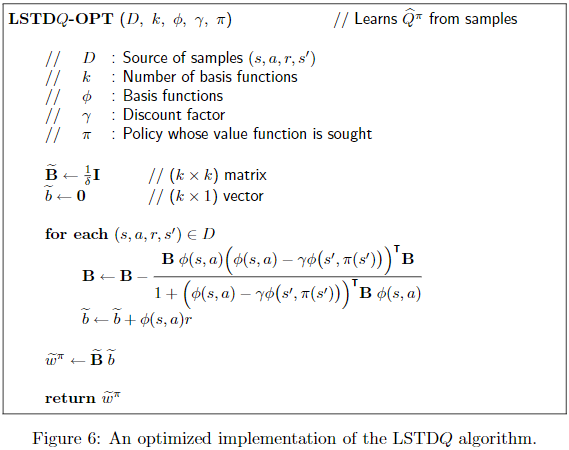

In [14]:
def LSTDQ( D, k, w ):

    B = DELTA * np.eye( k )
    b = np.zeros( k )

    for s, a, r, sP in D:

        phi_sa = np.matrix( phi(s, a) )
        phi_sPaP = np.matrix( phi( sP, policy( sP, w ) ) )

        numerator = np.dot( np.dot( B,
                                    np.dot( phi_sa.T,
                                            phi_sa - GAMMA * phi_sPaP ) ),
                                    B )
        
        denominator = 1 + np.dot( np.dot( phi_sa - GAMMA * phi_sPaP, B ).T,
                                  phi_sa )

        B = B - numerator / denominator

        b = b + phi_sa * r

    wP =  np.array( np.dot( B, b.T ).T )[0]
    
    w =  ALPHA * w + (1 - ALPHA) * wP 

    return( w )

## LSPI Implementation

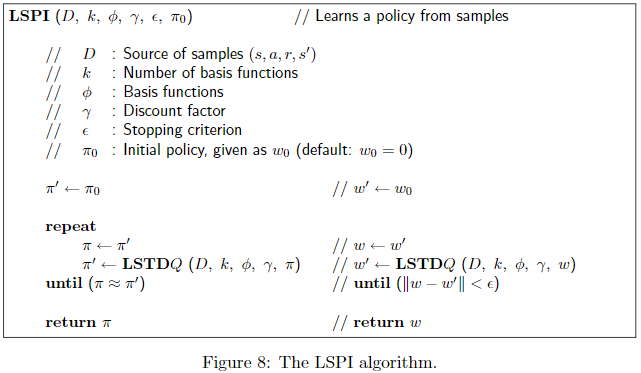

### LSPI as implemented above

In [15]:
def LSPI( k, M ):

    w = np.zeros( k )

    w_best = [{'w': w.copy(),
                'episode': -np.inf,
                'score': -np.inf,
                'mean': -np.inf,
                'hw': -np.inf }]

    print("LSPI Start")
    start_time = time.time()
    episode_scores = []

    for m in range( M ):

        np.random.seed( m )

        _, _, _, D = observe_env( w, num_episodes=10, seed=int( m * 1e3 ), num_samples = 64 )

        w = LSTDQ( D, k, w )

        mean, hw = update_best_score( w_best, w, m )
        episode_scores.append([m, mean, hw])

    env.close()

    end_time = time.time()

    clear_output(wait=True)

    print(f"LSPI Complete \t Runtime: {end_time - start_time:.2f} s")

    df_episode_scores = pd.DataFrame(episode_scores,
                                     columns=["episode", "mean", "hw"])

    return( w_best, df_episode_scores )

### LSPI using current best poilcy as $\pi$.

This method is similar to a memory used to remember the best policy.

In [16]:
def LSPIv2( k, M ):

    w = np.zeros( k )

    w_best = [{'w': np.zeros( k ),
                'episode': -np.inf,
                'score': -np.inf,
                'mean': -np.inf,
                'hw': -np.inf }]

    print("LSPI Start")
    start_time = time.time()
    episode_scores = []

    for m in range( M ):

        np.random.seed( m )

        _, _, _, D = observe_env(w, num_episodes=10, seed=int(m * 1e3), num_samples= 64 )

        # Note the use of w_best rather than w
        w = LSTDQ( D, k, w_best[0]['w'] )

        mean, hw = update_best_score( w_best, w, m )
        episode_scores.append([m, mean, hw])

    env.close()

    end_time = time.time()

    clear_output(wait=True)

    print(f"LSPI Complete \t Runtime: {end_time - start_time:.2f} s")

    df_episode_scores = pd.DataFrame(episode_scores,
                                     columns=["episode", "mean", "hw"])

    return( w_best, df_episode_scores )

### LSPI with delayed updates

# Run the LSPI Algorithms!

This is very interesting since it provides a policy for this problem using only $8 \times 4 = 32$ weights and still has a good score (i.e. $> 200$ if it ran correctly). This number of weights is much less than required to implement a Neural Network using [DQN](https://arxiv.org/abs/1312.5602) or not using Value Function Approximation and instead [discretizing the state space](https://arxiv.org/pdf/2011.11850).

In [17]:
# Number of episodes
M = 1000

# k for the number of basisi functions
k = len( phi( np.zeros( S_SIZE ), 0 ) )

## Run LSPI

In [18]:
w_best_lspi, episode_scores_lspi = LSPI( k, M )
print(f"Training for {M} epsisodes complete.")

LSPI Complete 	 Runtime: 1326.93 s
Training for 1000 epsisodes complete.


Episode 617 Eval: 212.00 +/- 13.24
Episode 609 Eval: 162.13 +/- 32.95
Episode 601 Eval: 141.89 +/- 34.59
Episode 441 Eval: 166.42 +/- 10.05
Episode 383 Eval: 91.36 +/- 45.33
Episode 121 Eval: 151.63 +/- 28.14
Episode 46 Eval: 113.56 +/- 52.88
Episode 42 Eval: 24.62 +/- 45.72
Episode 41 Eval: -9.13 +/- 32.65
Episode 40 Eval: -37.89 +/- 29.60
Superlative policy: Episode 617


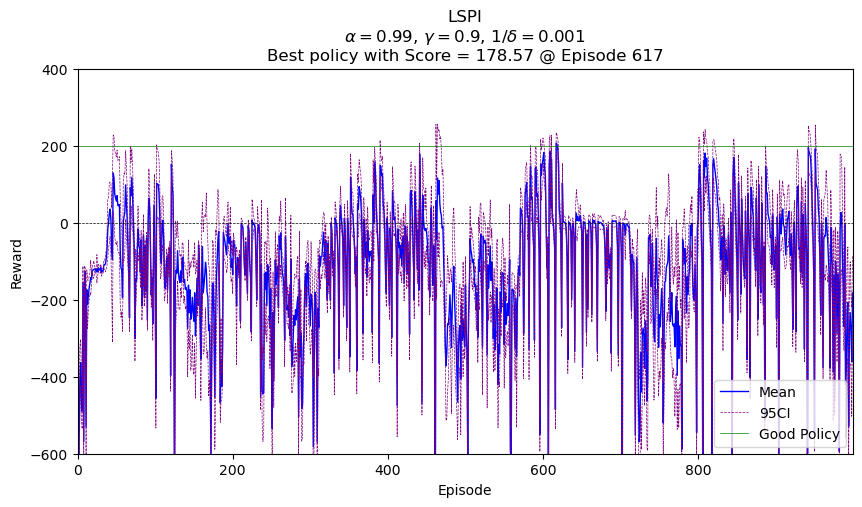

Superlative w for LSPIv1:
[[ 9.30928616e-04 -7.14586664e-03 -6.67254857e-04  6.97675737e-03
   5.22878333e-03  1.71501208e-03 -1.10752561e-04 -4.43590570e-04]
 [ 1.32364775e-03 -7.83066150e-03 -4.55757587e-05  5.94666484e-03
   2.94825884e-03 -2.14784709e-03 -1.67361809e-03 -8.23982737e-04]
 [ 6.35323385e-04 -9.14558185e-03 -1.22070734e-03  2.19989849e-03
   4.89892593e-03  1.33404242e-03 -1.26089271e-03  4.93492266e-04]
 [ 2.70356348e-04 -7.86568690e-03 -1.53491749e-03  5.80491037e-03
   8.31426730e-03  7.42901863e-04 -1.13424597e-03 -6.02896178e-04]]


In [19]:
os.makedirs(WEIGHTS_FOLDER, exist_ok=True)

superlative_lspi = determine_best_policy( w_best_lspi )

print(F"Superlative policy: Episode {superlative_lspi['episode']}")


plot_title = ( f"LSPI\n" +
               f"$\\alpha={ALPHA}$, $\\gamma={GAMMA}$, $1/\\delta={DELTA}$\n" +               
               f"Best policy with Score = {superlative_lspi['score']:.2f} @ Episode {superlative_lspi['episode']}" )


plot_learning_curve(episode_scores_lspi,
                    plot_title,
                    f"lspi-score-({superlative_lspi['score']:.2f}).png")

print("Superlative w for LSPIv1:")
print(superlative_lspi['w'].reshape(-1,S_SIZE))

In [20]:
fname = record_video(superlative_lspi['w'])
Video(fname, embed=True, width=600, height=400)

Video Recorded with Rewards
Episode 0 - Reward: 211.89
Episode 1 - Reward: 124.29
Episode 2 - Reward: 209.00
Episode 3 - Reward: 222.95
Episode 4 - Reward: 225.48
Episode 5 - Reward: 212.24
Episode 6 - Reward: 156.65
Episode 7 - Reward: 190.92
Episode 8 - Reward: 245.31
Episode 9 - Reward: 264.32


## Run LSPIv2

Run the adjusted version of LSPI noted above where updates accomplished using the current best policy rather than just the current policy.

In [21]:
# Number of episodes
w_best_lspiv2, episode_scores_lspi_v2 = LSPIv2( k, M )
print(f"Training for {M} epsisodes complete.")

LSPI Complete 	 Runtime: 1782.96 s
Training for 1000 epsisodes complete.


Episode 598 Eval: 197.22 +/- 22.46
Episode 593 Eval: 189.83 +/- 32.90
Episode 322 Eval: 184.11 +/- 33.09
Episode 254 Eval: 187.10 +/- 31.11
Episode 246 Eval: 173.96 +/- 33.15
Episode 201 Eval: 50.81 +/- 60.52
Episode 196 Eval: 82.00 +/- 56.59
Episode 195 Eval: 53.69 +/- 53.37
Episode 188 Eval: 48.16 +/- 55.81
Episode 187 Eval: 96.09 +/- 49.95
Superlative policy: Episode 598


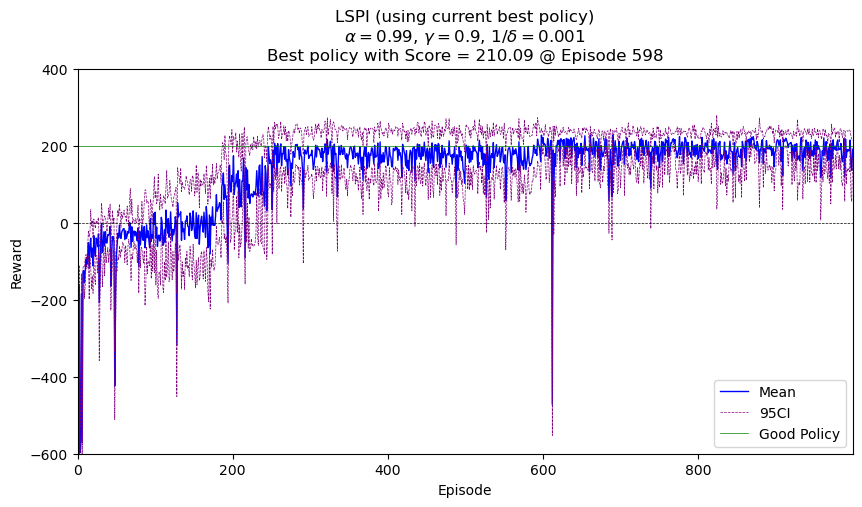

Superlative w for LSPIv2:
[[-1.37123478e-03 -2.55093016e-03  4.37063003e-04  1.41762213e-03
   2.03291206e-04  5.56690565e-03 -1.25918127e-03  1.27870796e-03]
 [ 1.14854635e-05 -2.14976364e-03  6.18255915e-04  1.95877478e-03
  -8.43989006e-04  4.92249729e-03  1.59536152e-04 -2.71733657e-04]
 [ 6.09714856e-04 -4.65468309e-03 -3.84402974e-04 -4.83624031e-03
   3.06333681e-03  3.54130053e-03 -1.60566546e-03 -1.12441837e-03]
 [-3.04973950e-04 -2.28240549e-03 -1.14176286e-03  1.81623478e-03
   1.05372093e-03  8.12811007e-03 -2.13491854e-03 -2.30079075e-03]]


In [22]:
superlative_lspiv2 = determine_best_policy( w_best_lspiv2 )

print(F"Superlative policy: Episode {superlative_lspiv2['episode']}")

plot_title = ( f"LSPI (using current best policy)\n" +
               f"$\\alpha={ALPHA}$, $\\gamma={GAMMA}$, $1/\\delta={DELTA}$\n" +               
               f"Best policy with Score = {superlative_lspiv2['score']:.2f} @ Episode {superlative_lspiv2['episode']}" )


plot_learning_curve(episode_scores_lspi_v2,
                    plot_title,
                    f"lspiv2-score-({superlative_lspiv2['score']:.2f}).png")

print("Superlative w for LSPIv2:")
print(superlative_lspiv2['w'].reshape(-1,S_SIZE))

In [23]:
fname = record_video(superlative_lspiv2['w'])
Video(fname, embed=True, width=600, height=400)

Video Recorded with Rewards
Episode 0 - Reward: 216.30
Episode 1 - Reward: 238.71
Episode 2 - Reward: 261.64
Episode 3 - Reward: 212.37
Episode 4 - Reward: 208.25
Episode 5 - Reward: 198.78
Episode 6 - Reward: 203.88
Episode 7 - Reward: 233.47
Episode 8 - Reward: 224.46
Episode 9 - Reward: 277.60
